# **Strategy**
We will get best models from each dataset that are created and fitting on all the train dataset(ie including the validation dataset) and also try ensembling them. The best models obtained were(from best to worst validation AUC):

| Rank | Model | Validation AUC |
| - | --------------------- | ----------- |
| 1. | XGBoost(all features) on Log with OHE dataset  | 0.848140 |
| 2. | XGBoost(top 250 features) on Log with RE dataset | 0.847824 |
| 3. | XGBoost(top 250 features) on Normal with OHE dataset | 0.846985 |
| 4. | XGBoost(top 250 features) on Normal dataset | 0.846664 |
| 5. | XGBoost(all features) on Log dataset | 0.846170 |
| 6. | XGBoost(top 250 features) on Normal with RE dataset | 0.845760 |                           

OHE: One Hot Encoding

RE: Response Encoding

In [1]:
import joblib #for loading pickle files
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb 
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

# **Methods**

In [2]:
def return_model(model,X_train,X_val,X_test,y_train,y_val):
  """
  Getting the train,test and validation dataset and model
  Fits the model on combined train+validation dataset and returns
  y_test and y_pred(of combined dataset).
  """
  X  =X_train.append(X_val).reset_index().drop('index',axis=1)
  y =np.append(y_train,y_val)
  
  #fitting
  model.fit(X,y)
  y_pred = model.predict_proba(X)[:,1]
  y_test = model.predict_proba(X_test)[:,1]
  return y_pred,y_test

In [3]:
df = {}
test_df = {}
def produce_y(y_pred,y_test,label):
  """
  given a label, adds the value of y_pred and y_test
  to the df and test_df dictionary
  """
  df[label] = y_pred
  test_df[label] = y_test

In [4]:
def find_best_params(X_train,y_train,model,params,cv=5,n_jobs=-1):
  """
  Funcion which implements Random Seacrh CV and returns best model with maximum score auc
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [5]:
def plot_auc(y_true,y_pred,label):
  """
  Plots auc curve when y_true and y_pred are given
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s \t\t \n"%(label))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) #getting true positive rate, false positive rate
    auc = metrics.roc_auc_score(y_true,y_pred) #getting auc score
    log_loss = metrics.log_loss(y_true,y_pred) #getting logloss
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1) #auc=0.5 line 
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s."%(log_loss,auc,label))
    # #creating a dataframe of the result
    # result_dict = {"Model":label,'log_loss':log_loss,'auc':auc}
    
    # return pd.DataFrame(result_dict,index=[i])

  else:
    plt.figure(figsize=(12,8))
    for k,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[k]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

In [6]:
def create_testy(y_test):
  """
  creates submission test file csv
  """
  test = pd.read_pickle('/content/drive/My Drive/applied ai assignment/X_test_2.pkl')
  feat = test.columns
  feat_to_drop = set(test.columns)-{'ID'}
  test.drop(feat_to_drop,axis=1,inplace=True)
  test['TARGET'] = y_test
  test.to_csv('./test.csv',index=False)

In [15]:
def plot_feature_importance(df,feat_imp,label,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat) #plotting feature importance 
    plt.title('Feature Importance '+label)
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [7]:
filepath = '/content/drive/My Drive/Santander_Customer_Satisfaction/best_models' #for loading dataset files

In [8]:
#y
y_train = joblib.load(os.path.join(filepath,'y_train.pkl'))
y_val = joblib.load(os.path.join(filepath,'y_val.pkl'))
y = np.append(y_train,y_val)

## **XGBoost(all features) on Log with OHE dataset**

In [ ]:
label = "log ohe xgb"
#train
file_name = 'log_train_ohe.pkl'
X_train = pd.read_pickle(os.path.join(filepath,file_name))

#val
file_name = 'log_val_ohe.pkl'
X_val = pd.read_pickle(os.path.join(filepath,file_name))

#test
file_name = 'log_test_ohe.pkl'
X_test = pd.read_pickle(os.path.join(filepath,file_name))



#model
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.7,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=500,
                      reg_alpha = 0.,
                      max_depth=5, random_state=42
                     )


y_pred,y_test = return_model(model,X_train,X_val,X_test,y_train,y_val) #fitting the model on train data and the producing y_pred and y_test
produce_y(y_pred,y_test,label) #updating it on df and test_df

## **XGBoost(top 250 features) on Log with RE dataset**

In [ ]:
label = "log re(top 250) xgb"

#train
file_name = 'log_train_re_250.pkl'
X_train = pd.read_pickle(os.path.join(filepath,file_name))

#val
file_name = 'log_val_re_250.pkl'
X_val = pd.read_pickle(os.path.join(filepath,file_name))

#test
file_name = 'log_test_re_250.pkl'
X_test = pd.read_pickle(os.path.join(filepath,file_name))



#model
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=945,
                      reg_alpha = 0.1,
                      max_depth=6,
                      gamma=0,
                     )


y_pred,y_test = return_model(model,X_train,X_val,X_test,y_train,y_val)
produce_y(y_pred,y_test,label)

## **XGBoost(top 250 features) on Normal with OHE dataset**

In [ ]:
label = "normal ohe(top 250) xgb"

#train
file_name = 'normal_train_ohe_250.pkl'
X_train = pd.read_pickle(os.path.join(filepath,file_name))

#val
file_name = 'normal_val_ohe_250.pkl'
X_val = pd.read_pickle(os.path.join(filepath,file_name))

#test
file_name = 'normal_test_ohe_250.pkl'
X_test = pd.read_pickle(os.path.join(filepath,file_name))



#model
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=710,
                      reg_alpha = 0.3,
                      max_depth=6, 
                      gamma=0, random_state=42
                     )
y_pred,y_test = return_model(model,X_train,X_val,X_test,y_train,y_val)
produce_y(y_pred,y_test,label)


## **XGBoost(top 250 features) on Normal dataset**

In [ ]:
label = "normal (top 250) xgb"
#train
file_name = 'normal_train_250.pkl'
X_train = pd.read_pickle(os.path.join(filepath,file_name))

#val
file_name = 'normal_val_250.pkl'
X_val = pd.read_pickle(os.path.join(filepath,file_name))

#test
file_name = 'normal_test_250.pkl'
X_test = pd.read_pickle(os.path.join(filepath,file_name))


#model
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=801,
                      reg_alpha = 0.3,
                      max_depth=6, 
                      gamma=0,random_state=42
                     )

y_pred,y_test = return_model(model,X_train,X_val,X_test,y_train,y_val)
produce_y(y_pred,y_test,label)

## **XGBoost(top 250 features) on Normal with RE dataset**

In [ ]:
%%time
label = "normal re(top 250) xgb"
#train
file_name = 'normal_train_re_250.pkl'
X_train = pd.read_pickle(os.path.join(filepath,file_name))

#val
file_name = 'normal_val_re_250.pkl'
X_val = pd.read_pickle(os.path.join(filepath,file_name))

#test
file_name = 'normal_test_re_250.pkl'
X_test = pd.read_pickle(os.path.join(filepath,file_name))


#model
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=865,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=1,
                      random_state=42
                     )

y_pred,y_test = return_model(model,X_train,X_val,X_test,y_train,y_val)
produce_y(y_pred,y_test,label)

CPU times: user 15min 13s, sys: 732 ms, total: 15min 13s
Wall time: 7min 49s


## **XGBoost(all features) on Log dataset**



In [ ]:
%%time
label = "log xgb"
#train
file_name = 'log_train.pkl'
X_train = pd.read_pickle(os.path.join(filepath,file_name))

#val
file_name = 'log_val.pkl'
X_val = pd.read_pickle(os.path.join(filepath,file_name))

#test
file_name = 'log_test.pkl'
X_test = pd.read_pickle(os.path.join(filepath,file_name))


#model
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=750,
                      reg_alpha = 0.2,
                      max_depth=6, 
                      gamma=0, random_state=42
                     )

y_pred,y_test = return_model(model,X_train,X_val,X_test,y_train,y_val)
produce_y(y_pred,y_test,label)

CPU times: user 13min 13s, sys: 878 ms, total: 13min 14s
Wall time: 6min 48s


In [ ]:
df = pd.DataFrame(df)
test_df = pd.DataFrame(test_df)

In [9]:
# df.to_pickle(os.path.join(filepath,'df.pkl'))
# test_df.to_pickle(os.path.join(filepath,'test_df.pkl'))
df = pd.read_pickle(os.path.join(filepath,'df.pkl'))
test_df = pd.read_pickle(os.path.join(filepath,'test_df.pkl'))

In [ ]:
test_df.columns

Index(['log ohe xgb', 'log re(top 250) xgb', 'normal ohe(top 250) xgb',
       'normal (top 250) xgb', 'normal re(top 250) xgb', 'log xgb'],
      dtype='object')

In [ ]:
create_testy(test_df['log ohe xgb'].values) #0.81851

In [ ]:
create_testy(test_df['log re(top 250) xgb'].values) #0.82734

In [ ]:
create_testy(test_df['normal ohe(top 250) xgb'].values) #0.81560

In [ ]:
create_testy(test_df['normal (top 250) xgb'].values) #0.81952

In [ ]:
create_testy(test_df['normal re(top 250) xgb'].values) #0.82713

In [ ]:
create_testy(test_df[ 'log xgb'].values) #0.81131

In [ ]:
result_df = {}
result_df['model'] = test_df.columns
result_df['kaggle public scoure(AUC)'] = [0.81851,0.82734,0.81560,0.81952,0.82713,0.81131]
result_df =pd.DataFrame(result_df)
result_df #df with descending kaggle public auc

,model,kaggle public scoure(AUC)
0,log ohe xgb,0.81851
1,log re(top 250) xgb,0.82734
2,normal ohe(top 250) xgb,0.81560
3,normal (top 250) xgb,0.81952
4,normal re(top 250) xgb,0.82713
5,log xgb,0.81131


# **Stacking**

Stacking a logistic regression model as meta classifier.

In [10]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }

In [11]:
find_best_params(df,y,model,params,cv=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.5s finished


The best auc score was 0.912
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 1.0}


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#logistic resgresion meta classifier
model = linear_model.LogisticRegression(class_weight='balanced',penalty='l2',fit_intercept=True,C=1.0)
model.fit(df,y)
y_test = model.predict_proba(test_df)[:,1] #0.82310
result_df.loc[6,'model'] = 'Stacking (logistic Regression)'
result_df.loc[6,'kaggle public scoure(AUC)'] = 0.82310

# **Ensembling**

We will take simple average of result of the two best model we got ie 'log re(top 250) xgb' and 'normal re(top 250) xgb'.

In [ ]:
y_test = test_df.loc[:,['log re(top 250) xgb','normal re(top 250) xgb']].mean(axis=1)
create_testy(y_test)#0.82746

In [ ]:
result_df.loc[7,'model'] = 'Ensembling(Simple average of two best models)'
result_df.loc[7,'kaggle public scoure(AUC)'] = 0.82746

In [ ]:
result_df = result_df.sort_values(by='kaggle public scoure(AUC)',ascending=False).reset_index(drop=True)
result_df

,model,kaggle public scoure(AUC)
0,Ensembling(Average of two best models),0.82746
1,log re(top 250) xgb,0.82734
2,normal re(top 250) xgb,0.82713
3,Stacking (logistic Regression),0.82310
4,normal (top 250) xgb,0.81952
5,log ohe xgb,0.81851
6,normal ohe(top 250) xgb,0.81560
7,log xgb,0.81131


# **Data interpretability**


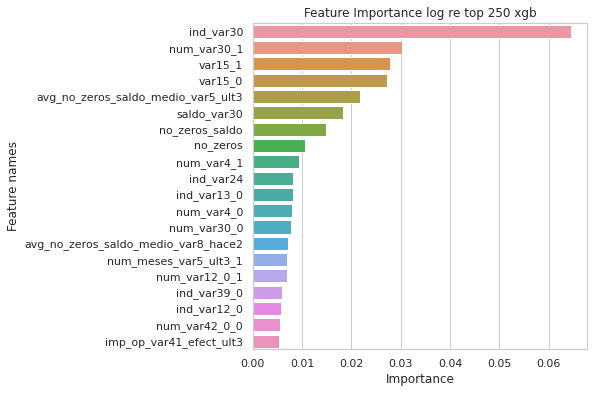

In [19]:
#log re top 250
#train
label = 'log re top 250 xgb'
file_name = 'log_train_re_250.pkl'
X_train = pd.read_pickle(os.path.join(filepath,file_name))

#val
file_name = 'log_val_re_250.pkl'
X_val = pd.read_pickle(os.path.join(filepath,file_name))

#test
file_name = 'log_test_re_250.pkl'
X_test = pd.read_pickle(os.path.join(filepath,file_name))



#model
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=945,
                      reg_alpha = 0.1,
                      max_depth=6,
                      gamma=0,
                     )
X = X_train.append(X_val)
#plotting top 20 features with highest imoprtance
model.fit(X,y)

plot_feature_importance(X,model.feature_importances_,label)

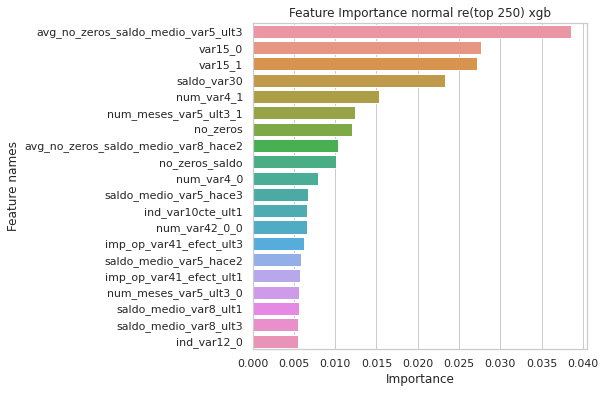

In [20]:
#normal re top 250
#train
label = "normal re(top 250) xgb"
#train
file_name = 'normal_train_re_250.pkl'
X_train = pd.read_pickle(os.path.join(filepath,file_name))

#val
file_name = 'normal_val_re_250.pkl'
X_val = pd.read_pickle(os.path.join(filepath,file_name))

#test
file_name = 'normal_test_re_250.pkl'
X_test = pd.read_pickle(os.path.join(filepath,file_name))


#model
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=865,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=1,
                      random_state=42
                     )
X = X_train.append(X_val)
#plotting top 20 features with highest imoprtance
model.fit(X,y)

plot_feature_importance(X,model.feature_importances_,label)

# **Conclusion**

We can see from the result dataframe above that XGB model fitted on Log transformed Response Encoded (top 250 features) dataset and XGB model fitted on Normal response encoded (top 250 features) performed very well. The simple average ensembling of these 2 models were able to achieve a kaggle public AUC score of 0.82763 which was just around 2% below the top score in public leaderboard (0.84532). The stacking model performed poorly as it had the worst public score. The response encoding the categorical features improved the models a lot since models trained on other dataset models did not produce great results compared to models trained on the response encoded datasets.

And also from the feature importance plot of the two models of the ensemble used, we can see that in both the models, the common feature which had highest importance was 'var15'(represents 'age' inferred from literature review) which implies that age is an important factor that determines whether a customer is satisfied or not. Also we can see some 'avg' (average) features which we added as feature in feature engineering in the plot.

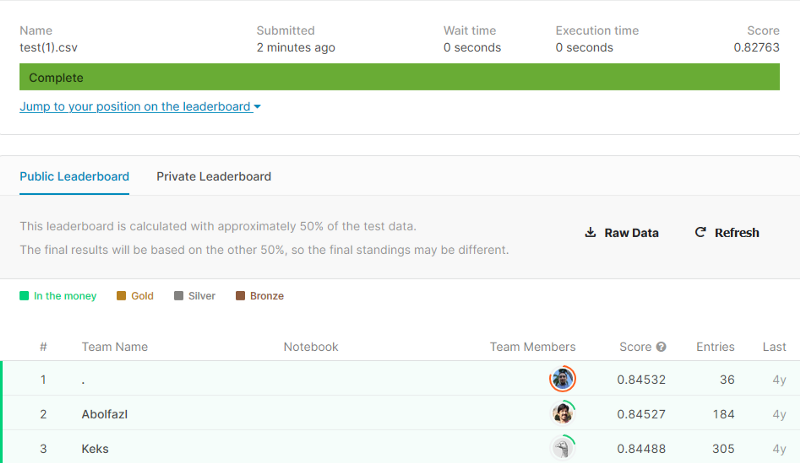